Markov state model Analysis
=====


First import the pyemma package and check if we have the right version number:

In [6]:
import pyemma
pyemma.__version__
pyemma.config.show_progress_bars = False

In [2]:
import numpy as np
from IPython.display import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We start by doing some more imports which were cover in the previous notebook, and defining some helpful functions

In [3]:
import pyemma.coordinates as coor

# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order 
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Load data and redo featurization, TICA, clustering and MSM estimation from yesterday


In [4]:
trajfile = 'data/bpti_ca_1ms_dt10ns.xtc'
topfile = 'data/bpti_ca.pdb'
feat = coor.featurizer(topfile)
# just use all xyz-coordinates
feat.add_all()
inp = coor.source(trajfile, feat)
print ('trajectory length = ',inp.trajectory_length(0))
print ('number of dimension = ',inp.dimension())
lag=100
tica_obj = coor.tica(inp, lag=lag, dim=2, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
print( 'Projected data shape = ',Y.shape)

cl = coor.cluster_kmeans(data=Y, k=100, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]
dtrajs = cl.dtrajs
import pyemma.msm as msm
import pyemma.plots as mplt

M = msm.estimate_markov_model(dtrajs, 100)

trajectory length =  103125
number of dimension =  174


Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Text(value=''), IntProgress(value=0)))

Projected data shape =  (103125, 2)


Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Text(value=''), IntProgress(value=0)))

30-01-18 15:11:11 pyemma.coordinates.clustering.kmeans.KmeansClustering[2] INFO     Cluster centers converged after 2 steps.


Box(children=(Text(value=''), IntProgress(value=0)))

Spectral analysis
-----------

Let us have a closer look at the timescales that were already seen in the its plot:

In [9]:
M.eigenvectors_right()[:,1].shape

(100,)

(-0.5, 10.5)

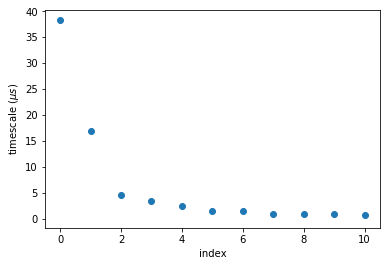

In [6]:
plot(M.timescales()*0.01,linewidth=0,marker='o')
xlabel('index'); ylabel(r'timescale ($\mu s$)'); xlim(-0.5,10.5)

We can also look at that data by taking the ratios of subsequent timescales. This shows us how big the gap of timescales (or rates) are.

(-0.5, 10.5)

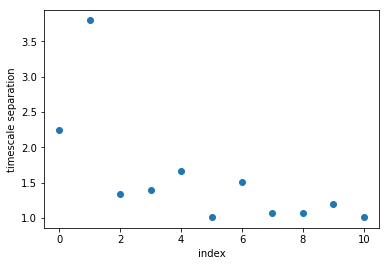

In [7]:
plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o')
xlabel('index'); ylabel('timescale separation'); xlim(-0.5,10.5)

It can be seen that there is a large timescale separation between the second and third relaxation timescale. That means that if we are interested in coarse-graining our dynamics, retaining two relaxation timescales, or three metastable states, is a good choice. Let's keep this in mind for later

### Eigenvectors

Eigenvectors are important when we want to know what is going on in the Markov models
Now let us look at the second (slowest) right eigenvector projected onto our cluster-centers

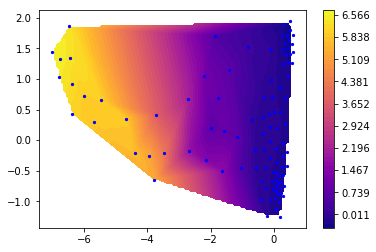

In [15]:
r2 = M.eigenvectors_right()[:,1]
ax = mplt.scatter_contour(cc_x, cc_y, r2, cmap='plasma',)

This eigenvector is associated with the slowest process (about 40 microseconds) and correlates well with the first TIC. This is great news for TICA, because it means that even before computing a Markov model we have done a very good job in finding a slow order parameter. However, remember that this process has occurred only once in the trajectory, so unfortunatly our data is quite poor with respect to quantifying it.

### Quick exercise
Try to plot the third eigenvector - what does it look like? what is the time-scale of this process?

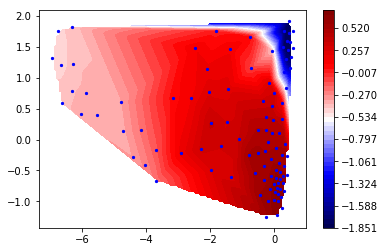

In [12]:
r3 = M.eigenvectors_right()[:,2]
ax = mplt.scatter_contour(cc_x, cc_y, r3, cmap='seismic',)

### Thermodynamics - The stationary distribution and Free energies
The MSM instance also has an attribute which contains the stationary distribution, $\boldsymbol{\pi}$. This  Use this to create a plot of the stationary distribution as with the eigenvectors.

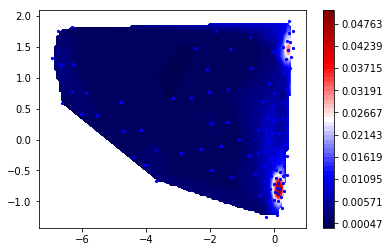

In [13]:
ax=mplt.scatter_contour(cc_x,cc_y,M.stationary_distribution, cmap='seismic')

This plots can sometimes be a bit peaked, making it difficult to see what is going on. In cases like this using a Free energy ($F$) instead can be useful:
$$ F_i = -kT\log(\pi_i)  $$ 
Compute the Free energies from the stationary distribution (use $kT=1$) and create a plot like above.

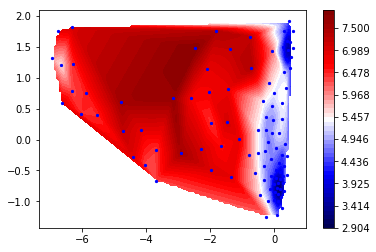

In [15]:
ax=mplt.scatter_contour(cc_x,cc_y,-np.log(M.stationary_distribution), cmap='seismic')

What is the difference between this Free energy plot and the Free energy plot generated using the pyemma plotting function mplt.plot_free_energy? 

Experimental observables
-------------

 Now let us play some hypothetical games with experimental observables. We would like to design
 an experiment that allows us to resolve the slowest process in BPTI. By looking at the structures
 we find that the distance between residue 10 - 34 (indexes 9 - 33) exhibits a significant change.
 This is a difference we could measure by a fluorescent probe or by some other experiment

Here we use the feature reader to just read this one distance and get it as a vector:

In [16]:
feat2 = coor.featurizer(topfile)
feat2.add_distances(np.array([[9,33]]))
D = coor.load(trajfile, feat2)
#Image(filename='./data/observable.png', width=500) 

Let us compare this experimental observable with the slowest TIC...


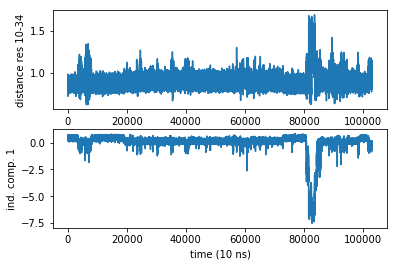

In [17]:
subplot2grid((2,1),(0,0))
plot(D)
ylabel('distance res 10-34')
subplot2grid((2,1),(1,0))
plot(Y[:,0])
ylabel('ind. comp. 1')
xlabel('time (10 ns)')

 You can see that the variations are roughly between 0.8 and 1.5 nanometers. This is actually the perfect distance
 for FRET (although I'm sure that the bulky FRET labels would mess up everything here, but again this is just a 
 hypothetical game). On the other hand they might be close enough to use fluorescence quenching. So one option is 
 to check if there are any trytophanes nearby that can be used as a quencher - that way we could get away with one
 extrinsic fluorophore.

We can compute the average distance in each microstate using the helper-function defined above:


In [18]:
dmean = average_by_state(dtrajs[0], D, M.nstates)

Try to make a plot of the distances projected onto the cluster-centers. (hint: do as for the eigenvectors etc.)

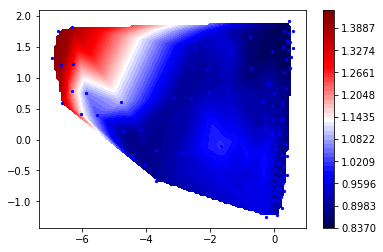

In [19]:
ax=mplt.scatter_contour(cc_x,cc_y,dmean, cmap='seismic')


### Simulating experiments
Imagine we can measure the ensemble-average distance in an experiment. We can use our MSM instance to compute this quantity using the expectation method:

In [20]:
M.expectation(dmean)

0.90940661545002122

Similarly, we can simulate correlation experiments from fx FRET, NMR or SANS [6,9,10]. In the case of FRET it is very easy: we can just use the distance observable from before and use the correlation method:

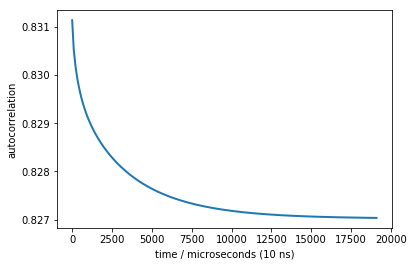

In [21]:
times, corr = M.correlation(dmean)
plot(times, corr, linewidth=2)
xlabel('time / microseconds (10 ns)')
ylabel('autocorrelation')

 We do see a nice decay that contains our slowest timescale.
 Unfortunately, the change in the signal (y-axis) is really small, so that we cannot expect to see anything in
 the presence of experimental errors.
 The problem is that the extra state is too sparsely populated - in an equilibrium measurement such as FCS
 it will have too little contribution, and this is why the amplitude is so small.
 

 We need to find a way to increase the amplitude of the signal. The observable is already pretty good, we can't get
 much better there. But we can do a different experiment that hopefully gives a larger signal: Let us do a 
 perturbation-relaxation experiment. Suppose we would have some way of preparing our ensemble in the low-populated
 state of interest (different temperature, pH, pressure, ...?), and then let the system relax towards equilibrium while we
 measure the expectation of the fluorescence.

In [25]:
p0 = np.zeros(np.shape(M.stationary_distribution))
len(p0)

100

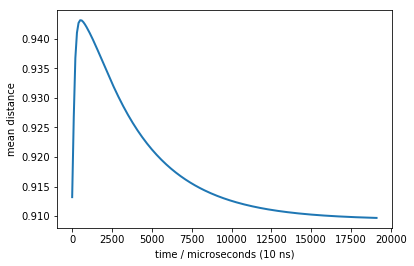

In [22]:
# define the prepared state (least populated Markov state equal to a probability of 1, everything else 0)
p0 = np.zeros(np.shape(M.stationary_distribution))
p0[M.stationary_distribution.argmin()] = 1

times, rel = M.relaxation(p0, dmean)
plot(times, rel, linewidth=2)
xlabel('time / microseconds (10 ns)')
ylabel('mean distance')

 Now we can see a much stronger signal (variation between 0.9 and 1.4) - this will be measurable even with large
 experimental errors.

 This is a very nice and clear observable. If we only could measure whatever we wanted...
 
 now let's plot the relaxation curve in a log-plot.
 And let's add single exponentials with the MSM timescales (showing up as lines), to see if we can match timescales 

In [ ]:
plot(times, rel-M.expectation(dmean), linewidth=5)
t2_tau = M.timescales()[0]
plot(times, 0.29*np.exp(-times / t2_tau), color='yellow', linestyle='dashed', linewidth=2)
semilogy()
xlabel('time / microseconds (tau)')
ylabel('distance perturbation')

 We can nicely see that the main part of the relaxation is exactly due to the slow process. So we have designed an
 experiment that can measure the slow process!
 
A more systematic analysis could be done using dynamical fingerprints concept described in [6]. Briefly, the eigenvectors are used to compute amplitudes of the relaxation signal, and the time-scales defines the relaxation time-scale.

### Exercises
1. Take a look at the fingerprint_correlation and fingerprint_relaxation methods. What do they compute? (Hint look at the documentation on the PyEMMA homepage)
2. Explain why only the slowest process visibly contributes to the signal seen above?
3. Is it hypothetically possible to change the initial conditions to make the other processes visible?

References
------

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,
Wriggers W: Atomic-level characterization of the structural dynamics of proteins.
*Science* **330**:341-346 (2010). doi: 10.1126/science.1187409.
2. Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).
3. Pérez-Hernández, G. and Paul, F. and Giogino, T. and de Fabritiis, G. and Noé, F. Identification of slow molecular order parameters for Markov model construction. *J. Chem. Phys.* **139**:015102 (2013)
4. Swope WC, Pitera JW and Suits F. Describing protein folding kinetics by molecular dynamics simulations: 1. Theory. 
*J. Phys. Chem. B* **108**:6571-6581 (2004)
5. Röblitz S. and M. Weber: Fuzzy spectral clustering by PCCA+: application to Markov state models and data classification. Adv. Data. Anal. Classif. DOI 10.1007/s11634-013-0134-6 (2013) 
6. Noé F, Doose S, Daidone I, Löllmann M, Chodera JD, Sauer M, Smith JC. Dynamical fingerprints for probing individual relaxation processes in biomolecular dynamics with simulations and kinetic experiments. *Proc. Natl. Acad. Sci. USA*, **108**: 4822-4827 (2011)
7. Metzner P, Schütte C, Vanden-Eijnden, E. Transition Path Theory for Markov Jump Processes. *Multiscale Model. Simul.* **7**. 1192--1219 (2009)
8. Noé F, Schütte C, Vanden-Eijnden E, Reich L and Weikl T. Constructing the Full Ensemble of Folding Pathways from Short Off-Equilibrium Simulations. *Proc. Natl. Acad. Sci. USA*, **106**:19011-19016 (2009)
9. Lindner B, Yi Z, Prinz JH, Smith JC, Noé F. Dynamic neutron scattering from conformational dynamics. I. Theory and Markov models. * JCP * 139:175101 (2013)
10. Olsson S, Noé F. Mechanistic Models of Chemical Exchange Induced Relaxation in Protein NMR *J. Am. Chem. Soc*, **139**:200–210 (2017)